This notebook defines the modeling target using sales data.

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import requests
import time
import json
import datetime
from tqdm import tqdm
strptime = datetime.datetime.strptime
plt.rcParams['figure.figsize'] = (16, 4)

Load data from CSV.

In [2]:
raw = pd.read_csv('sales_granular.csv')

In [3]:
raw.shape

(906, 11937)

In [212]:
df = raw.set_index('store_code')

Some of store codes are duplicates, we remove them.

In [214]:
dups = df.index[df.index.duplicated()].unique()
df = df[~df.index.isin(dups)]

Int64Index([11028], dtype='int64', name='store_code')

In [216]:
df = df.T

In [217]:
df.index = pd.to_datetime(df.index)

Final dataframe shape is `(n_timestamps, n_stores)`.

In [219]:
df.shape

(11936, 902)

In [236]:
def meta(df, s):
    """Dynamicaly add a new attribute based on index, e.g. `day`"""
    return df.join(pd.Series(getattr(df.index, s), index=df.index, name=s))

We would like to plot store activity during a given hour of day per store. To do this, we first normalize the activity relative to the rest of the activity of the same store, then groupby by `hour` and take average activity within the hour.

In [35]:
d = (df - df.mean()) / df.std()
d = meta(df, 'hour').groupby(['hour']).mean()

We see that most store, apart from a few exceptions, are only active during daytime. There are no clear segments of activity (e.g. most active during lunch).

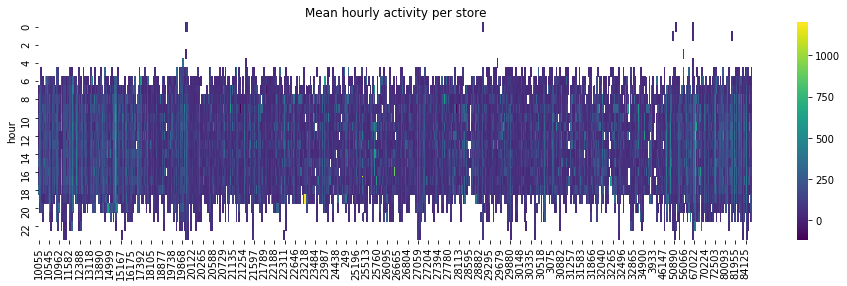

In [40]:
sns.heatmap(d, cmap='viridis')
plt.title('Mean hourly activity per store');

When we do the same for day of the week (instead of hour of day), we see that most store are inactive on Sundays.

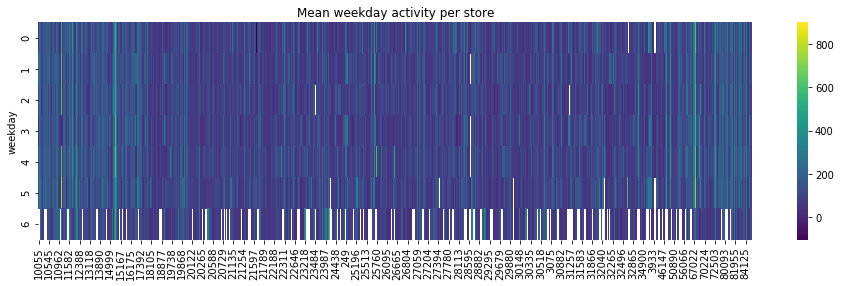

In [45]:
d = (df - df.mean()) / df.std()
d = meta(df, 'weekday').groupby(['weekday']).mean()

sns.heatmap(d, cmap='viridis')
plt.title('Mean weekday activity per store');

Our time series granularity is irregular, with 1 hour being the most common time delta. We resample the entire data set using 1-hour rule to make it more consistent.

In [220]:
pd.Series(df.index).diff().value_counts()

01:00:00    11089
07:00:00      222
08:00:00      154
02:00:00      137
06:00:00      119
09:00:00       85
10:00:00       43
05:00:00       26
03:00:00       21
11:00:00       12
04:00:00       12
12:00:00        9
14:00:00        4
13:00:00        2
dtype: int64

In [46]:
df = df.resample('1h').mean()

Since store activity can be subject to many fluctuations throught the day or even week, we will resample the data using 1-week windows. This means that every sample will now tell total sales volumes within past week. This will smooth out fluctuations due to variations in activity during different parts of day and weekends, and is more relatable to our goals in identifying store with higher sales.

Potential work:
- use different resampling
- depending on the goal, taken into account day and weekday information

In [221]:
df2 = df.resample('7d').sum()

In [223]:
df2.shape

(99, 902)

In [237]:
df2.head()

store_code,10055,10077,10079,10081,10085,10086,10111,10176,10377,10384,...,84089,84125,84128,84146,84219,84223,84351,84608,84658,85011
2015-08-03 09:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3870.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-08-10 09:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3240.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-08-17 09:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6660.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-08-24 09:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,10230.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-08-31 09:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,7530.0,0.0,0.0,0.0,0.0,0.0,0.0


Below, we plot total weekly activity for a sample of stores. We see that most stores have been open relatively recently.

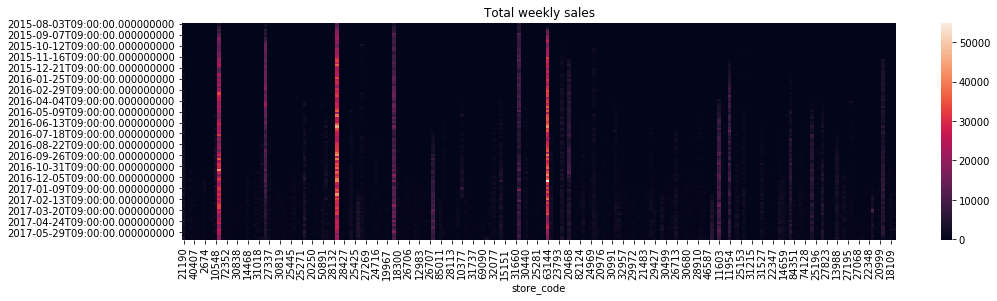

In [239]:
sns.heatmap(df2.T.sample(200, random_state=0).T)
plt.title('Total weekly sales');

There is a number of stores with negative weekly sales. Since this number is small, we will remove those stores altogether.

Potential work:
- in case different type of resampling was used, we may want to keep negative sales for further analysis

In [225]:
a = (df2 < 0).sum()
a[a > 0]

store_code
10548    1
21644    1
23291    1
23858    1
27996    1
32412    1
34713    1
50891    1
dtype: int64

In [227]:
df3 = df2[a[a == 0].index]

Since the spread of numbers is so large, we will use inverse hyperbolic sine transform.

- alternatively log-transform can be used

In [229]:
df3 = np.arcsinh(df3)

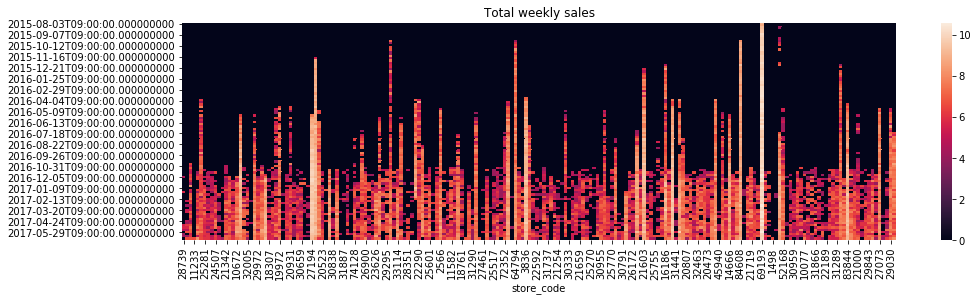

In [245]:
sns.heatmap(df3.T.sample(200, random_state=0).T)
plt.title('Total weekly sales');

In the end, we define our target as average of total weekly sales for a given store. The average disregards rows where sales are null, so that stores that opened more recently have as equal weight.

Possible work
- have a cut-off point and only consider sales later than this point; this will prioritize recent activity
- alternatively, use weighted average to prioritize recent activity

In [230]:
target = df3.mean(0)

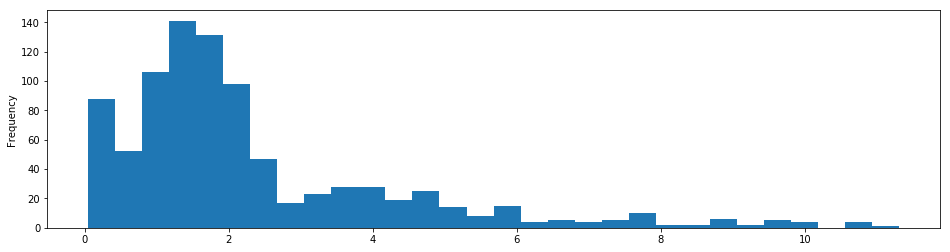

In [231]:
target.plot.hist(bins=30)

Sorted the target and plotting it for each store shows that, in general, stores that have been active for longer, have higher  weekly sales.

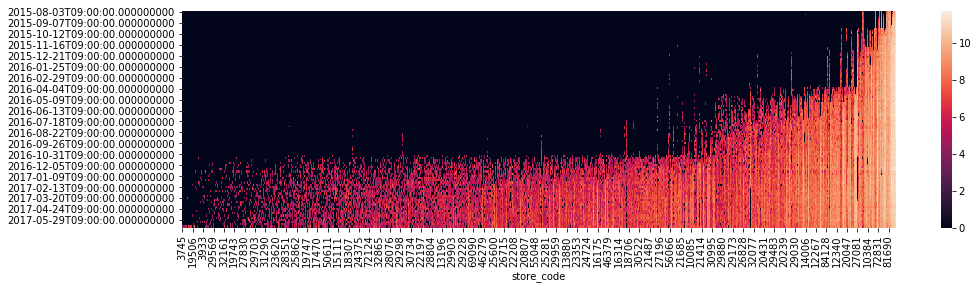

In [233]:
sns.heatmap(df3[target.sort_values().index])

In [234]:
target.to_frame('target').to_csv('target.csv')